<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    👋 Hi everyone! 🌟
</h1>

<p style="
    text-align: center; 
    font-size: 1.2em;
    margin-bottom: 25px;
    position: relative;
    z-index: 1;
    font-weight: 500;
">
    I hope this notebook will be useful for beginners! 🚀
</p>

<div style="
    background: rgba(163, 230, 53, 0.1);
    border-left: 4px solid #a3e635;
    border-radius: 8px;
    padding: 20px;
    margin: 20px 0;
    position: relative;
    z-index: 1;
">
    <h3 style="
        color: #a3e635;
        margin-top: 0;
        font-size: 1.3em;
        display: flex;
        align-items: center;
        gap: 10px;
    ">
        🎯 Task: <span style="color: #f1f5f9;">Semantic Segmentation</span>
    </h3>
</div>

<div style="
    background: rgba(255, 255, 255, 0.05);
    border-radius: 10px;
    padding: 20px;
    position: relative;
    z-index: 1;
">
    <h3 style="
        color: #a3e635;
        margin-top: 0;
        font-size: 1.3em;
        display: flex;
        align-items: center;
        gap: 10px;
    ">
        ⚡ Challenges:
    </h3>
    <ul style="
        color: #f1f5f9;
        font-size: 1.1em;
        line-height: 1.6;
        margin-bottom: 0;
    ">
        <li>🖼️ Different sizes of images</li>
        <li>🧠 Difficult task for conventional models</li>
        <li>⚠️ Penalties for mistakes</li>
    </ul>
</div>

<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    Importing libraries
</h1>

In [1]:
import os
import cv2
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import MaskRCNN
from sklearn.model_selection import train_test_split
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F_transforms

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [2]:
class CONFIG:
    test_images_path = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
    sample_sub_path = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 512
    use_tta = True
    ensemble_strategy = "average"
    min_area = 150
    min_confidence = 0.33

In [3]:
def analyze_data_structure():
    base_path = '/kaggle/input/recodai-luc-scientific-image-forgery-detection'

    # Checking train images
    train_authentic_path = os.path.join(base_path, 'train_images/authentic')
    train_forged_path = os.path.join(base_path, 'train_images/forged')
    train_masks_path = os.path.join(base_path, 'train_masks')
    test_images_path = os.path.join(base_path, 'test_images')

    print(f"Authentic images: {len(os.listdir(train_authentic_path))}")
    print(f"Forged images: {len(os.listdir(train_forged_path))}")
    print(f"Masks: {len(os.listdir(train_masks_path))}")
    print(f"Test images: {len(os.listdir(test_images_path))}")

    # Let's analyze some examples of masks
    mask_files = os.listdir(train_masks_path)[:5]
    print(f"Examples of mask files: {mask_files}")

    # Checking the mask format
    sample_mask = np.load(os.path.join(train_masks_path, mask_files[0]))
    print(f"Mask format: {sample_mask.shape}, dtype: {sample_mask.dtype}")

    test_files = os.listdir(test_images_path)
    print(f"Test images: {test_files}")

    return {
        'train_authentic': train_authentic_path,
        'train_forged': train_forged_path,
        'train_masks': train_masks_path,
        'test_images': test_images_path
    }

paths = analyze_data_structure()

Authentic images: 2377
Forged images: 2751
Masks: 2751
Test images: 1
Examples of mask files: ['59069.npy', '64134.npy', '18929.npy', '36106.npy', '422.npy']
Mask format: (1, 512, 711), dtype: uint8
Test images: ['45.png']


<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    Dataset Implementation for Forgery Detection
</h1>

In [ ]:
class ForgeryDataset(Dataset):
    def __init__(self, authentic_path, forged_path, masks_path, transform=None, is_train=True):
        self.transform = transform
        self.is_train = is_train

        # Collect all data samples
        self.samples = []

        # Authentic images
        for file in os.listdir(authentic_path):
            img_path = os.path.join(authentic_path, file)
            base_name = file.split('.')[0]
            mask_path = os.path.join(masks_path, f"{base_name}.npy")

            self.samples.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'is_forged': False,
                'image_id': base_name
            })

        # Forged images
        for file in os.listdir(forged_path):
            img_path = os.path.join(forged_path, file)
            base_name = file.split('.')[0]
            mask_path = os.path.join(masks_path, f"{base_name}.npy")

            self.samples.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'is_forged': True,
                'image_id': base_name
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample['image_path']).convert('RGB')
        image = np.array(image)  # (H, W, 3)

        # Load and process mask
        if os.path.exists(sample['mask_path']):
            mask = np.load(sample['mask_path'])

            # Handle multi-channel masks
            if mask.ndim == 3:
                if mask.shape[0] <= 10:  # channels first (C, H, W)
                    mask = np.any(mask, axis=0)
                elif mask.shape[-1] <= 10:  # channels last (H, W, C)
                    mask = np.any(mask, axis=-1)
                else:
                    raise ValueError(f"Ambiguous 3D mask shape: {mask.shape}")

            mask = (mask > 0).astype(np.uint8)
        else:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Shape validation
        assert image.shape[:2] == mask.shape, f"Shape mismatch: img {image.shape}, mask {mask.shape}"

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            image = F_transforms.to_tensor(image)
            mask = torch.tensor(mask, dtype=torch.uint8)

        # Prepare targets for Mask R-CNN
        if sample['is_forged'] and mask.sum() > 0:
            boxes, labels, masks = self.mask_to_boxes(mask)

            target = {
                'boxes': boxes,
                'labels': labels,
                'masks': masks,
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
            }
        else:
            # For authentic images or images without masks
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'masks': torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }

        return image, target

    def mask_to_boxes(self, mask):
        """Convert segmentation mask to bounding boxes for Mask R-CNN"""
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy()
        else:
            mask_np = mask

        # Find contours in the mask
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        boxes = []
        masks = []

        for contour in contours:
            if len(contour) > 0:
                x, y, w, h = cv2.boundingRect(contour)
                # Filter out very small regions
                if w > 5 and h > 5:
                    boxes.append([x, y, x + w, y + h])
                    # Create binary mask for this contour
                    contour_mask = np.zeros_like(mask_np)
                    cv2.fillPoly(contour_mask, [contour], 1)
                    masks.append(contour_mask)

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            masks = torch.tensor(np.array(masks), dtype=torch.uint8)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            masks = torch.zeros((0, mask_np.shape[0], mask_np.shape[1]), dtype=torch.uint8)

        return boxes, labels, masks

# Transformations for learning
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    Creating datasets and dataloaders
</h1>

In [ ]:
full_dataset = ForgeryDataset(
    paths['train_authentic'],
    paths['train_forged'],
    paths['train_masks'],
    transform=train_transform
)

# Split into train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Changing transformations for the val dataset
val_dataset.dataset.transform = val_transform

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Train samples: 4102
Val samples: 1026


<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    Creating a lightweight Mask R-CNN model
</h1>

In [ ]:
def create_light_mask_rcnn(num_classes=2, backbone="small"):
    # Select backbone
    if backbone == "large":
        backbone_features = torchvision.models.mobilenet_v3_large(pretrained=False).features
    elif backbone == "mnasnet1_3":
        backbone_features = torchvision.models.mnasnet1_3(weights=None).layers
    else:
        backbone_features = torchvision.models.mobilenet_v3_small(pretrained=False).features

    # Infer output channels of the backbone dynamically (robust to variant changes)
    with torch.no_grad():
        dummy = torch.zeros(1, 3, 256, 256)
        out = backbone_features(dummy)
        in_channels = out.shape[1]

    # Reduce channel dims to 256 for Mask R-CNN heads
    backbone = nn.Sequential(
        backbone_features,
        nn.Conv2d(in_channels, 256, kernel_size=1),
        nn.ReLU(inplace=True)
    )
    backbone.out_channels = 256

    # Anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # ROI pools
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=5,
        sampling_ratio=1
    )

    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=10,
        sampling_ratio=1
    )

    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        mask_roi_pool=mask_roi_pooler,
        min_size=224,
        max_size=224,
        rpn_pre_nms_top_n_train=1000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=200,
        rpn_post_nms_top_n_test=200,
        box_detections_per_img=100
    )

    return model

# Use large backbone for evaluation (change to "mnasnet1_3" to try MNASNet)
model = create_light_mask_rcnn(backbone="large")
model.to(CONFIG.device)

print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of parameters: 11,917,928


<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    Functions for train and validate
</h1>

In [ ]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Training")):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.train()  # For validation, we use train mode because of the features of Mask R-CNN
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Validation")):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    return total_loss / len(dataloader)

<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    Learn our R-CNN small model
</h1>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 3
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, CONFIG.device)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate_epoch(model, val_loader, CONFIG.device)
    val_losses.append(val_loss)

    # Scheduler step
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # We save the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f'mask_rcnn_epoch_{epoch+1}.pth')

Epoch 1/3


Validation: 100%|██████████| 257/257 [01:05<00:00,  3.92it/s]


Train Loss: 0.5812, Val Loss: 0.5298
Epoch 2/3


Validation: 100%|██████████| 257/257 [00:52<00:00,  4.85it/s]


Train Loss: 0.5460, Val Loss: 0.5350
Epoch 3/3


Validation: 100%|██████████| 257/257 [00:54<00:00,  4.71it/s]

Train Loss: 0.5311, Val Loss: 0.5310


In [9]:
from metric import *

In [10]:
predictions = []
image_files = sorted([f for f in os.listdir(CONFIG.test_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))])

In [11]:
# Transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
model.eval()

for image_name in image_files:
    image_path = Path(CONFIG.test_images_path) / image_name
    image = Image.open(image_path).convert("RGB")

    image_array = np.array(image.resize((CONFIG.img_size, CONFIG.img_size)), np.float32) / 255
    transformed = transform(image=image_array)
    image_tensor = transformed['image'].unsqueeze(0).to(CONFIG.device)

    pred = model(image_tensor)

    # mask = postprocess(final_pred, image.size)
    mask = pred[0]['masks']
    area = int(mask.sum())

    if area > 0:
        mask_resized = cv2.resize(mask, (CONFIG.img_size, CONFIG.img_size), interpolation=cv2.INTER_NEAREST)
        mean_inside = float(pred[mask_resized == 1].mean()) if (mask_resized == 1).any() else 0.0
    else:
        mean_inside = 0.0

    if area < CONFIG.min_area or mean_inside < CONFIG.min_confidence:
        annotation = "authentic"
    else:
        annotation = rle_encode(mask)

    predictions.append({
        "case_id": Path(image_name).stem,
        "annotation": annotation
    })

In [ ]:
# Diagnostic: check mask branch and cv2 behavior after switching to large backbone
model.eval()

# Pick one test image deterministically
if len(image_files) > 0:
    image_name = image_files[0]
    image_path = Path(CONFIG.test_images_path) / image_name

    # Use the same preprocessing as in the inference loop
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image.resize((CONFIG.img_size, CONFIG.img_size)), np.float32) / 255
    transformed = transform(image=image_array)
    image_tensor = transformed['image'].unsqueeze(0).to(CONFIG.device)

    with torch.no_grad():
        pred = model(image_tensor)

    masks_t = pred[0]['masks']
    scores_t = pred[0].get('scores', torch.tensor([]))

    print("masks:", type(masks_t), getattr(masks_t, 'shape', None), getattr(masks_t, 'device', None))
    print("scores:", type(scores_t), getattr(scores_t, 'shape', None))

    n = masks_t.shape[0] if hasattr(masks_t, 'shape') else 0
    if n > 0:
        # Combine instance masks into single 2D numpy mask safely
        bin_mask2d = (masks_t[:, 0] > 0.5).any(0).detach().cpu().numpy().astype(np.uint8)
        print("bin_mask2d:", type(bin_mask2d), bin_mask2d.shape, bin_mask2d.dtype)
        try:
            _ = cv2.resize(bin_mask2d, (CONFIG.img_size, CONFIG.img_size), interpolation=cv2.INTER_NEAREST)
            print("cv2.resize: OK")
        except Exception as e:
            print("cv2.resize: ERROR =>", repr(e))
    else:
        print("No instances found: area=0 branch would skip cv2.resize")
else:
    print("No test images found; diagnostic skipped.")

In [ ]:
## begug
base_path = '/kaggle/input/recodai-luc-scientific-image-forgery-detection'

# Checking train images
# train_authentic_path = os.path.join(base_path, 'train_images/authentic')
train_forged_path = os.path.join(base_path, 'train_images/forged')

train_image_files = sorted([f for f in os.listdir(train_forged_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))])

In [ ]:
train_image_files[:20]

In [ ]:
for image_name in train_image_files[:3]:
    image_path = Path(train_forged_path) / image_name
    image = Image.open(image_path).convert("RGB")

    image_array = np.array(image.resize((CONFIG.img_size, CONFIG.img_size)), np.float32) / 255
    transformed = transform(image=image_array)
    print(transformed)
    image_tensor = transformed['image'].unsqueeze(0).to(CONFIG.device)
    print(image_tensor)

    pred = model(image_tensor)
    print(pred)

    # mask = postprocess(final_pred, image.size)
    mask = pred[0]['masks']
    area = int(mask.sum())

    if area > 0:
        mask_resized = cv2.resize(mask, (CONFIG.img_size, CONFIG.img_size), interpolation=cv2.INTER_NEAREST)
        mean_inside = float(pred[mask_resized == 1].mean()) if (mask_resized == 1).any() else 0.0
    else:
        mean_inside = 0.0

    if area < CONFIG.min_area or mean_inside < CONFIG.min_confidence:
        annotation = "authentic"
    else:
        annotation = rle_encode(mask)

    predictions.append({
        "case_id": Path(image_name).stem,
        "annotation": annotation
    })

## forgedのデータを使用してもすべてauthenticと予測される

In [13]:
predictions_df = pd.DataFrame(predictions)
predictions_df["case_id"] = predictions_df["case_id"].astype(str)

submission = pd.read_csv(CONFIG.sample_sub_path)
submission["case_id"] = submission["case_id"].astype(str)
submission = submission[["case_id"]].merge(predictions_df[["case_id", "annotation"]], on="case_id", how="left")

submission["annotation"] = submission["annotation"].fillna("authentic")
submission[["case_id", "annotation"]].to_csv("submission.csv", index=False)

In [14]:
submission = pd.read_csv('/kaggle/working/submission.csv')
submission.head()

,case_id,annotation
0,45,authentic


## score
- mobilenet_v3_small: 3.03

<div style="
    background: linear-gradient(135deg, #1a2f0c 0%, #2d4a1a 50%, #4a4a1a 100%);
    border: 2px solid #a3e635;
    border-radius: 15px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 0 30px rgba(163, 230, 53, 0.4),
                inset 0 0 20px rgba(255, 255, 255, 0.1);
    color: #f1f5f9;
    font-family: 'Segoe UI', system-ui, sans-serif;
    position: relative;
    overflow: hidden;
">

<div style="
    position: absolute;
    top: -20px;
    right: -20px;
    width: 100px;
    height: 100px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.25) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<div style="
    position: absolute;
    bottom: -40px;
    left: -40px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(163, 230, 53, 0.2) 0%, transparent 70%);
    border-radius: 50%;
"></div>

<h1 style="
    color: #a3e635;
    margin: 0 0 20px 0;
    text-align: center;
    font-weight: 700;
    font-size: 1.8em;
    text-shadow: 0 0 15px rgba(163, 230, 53, 0.6);
    position: relative;
    z-index: 1;
">
    Create submission file
</h1>

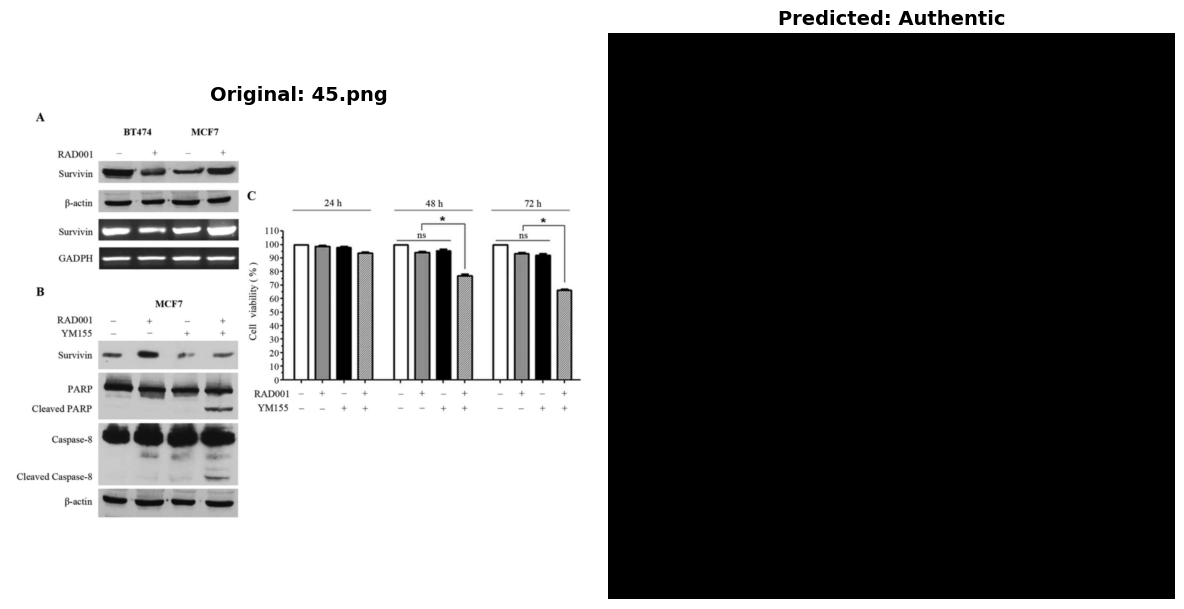

In [ ]:
model.eval()

# We take the first file from the test folder
test_files = sorted(os.listdir(paths['test_images']))
file = test_files[0]
img_path = os.path.join(paths['test_images'], file)

# Uploading an image
image = Image.open(img_path).convert('RGB')
image_np = np.array(image)

# Transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Apply transformations and make predictions
transformed = transform(image=image_np)
image_tensor = transformed['image'].unsqueeze(0).to(CONFIG.device)

with torch.no_grad():
    prediction = model(image_tensor)

masks = prediction[0]['masks']
scores = prediction[0]['scores']
confidence_threshold = 0.5
valid_detections = scores > confidence_threshold

# Creating a shape: original on the left, mask on the right
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original
axes[0].imshow(image_np)
axes[0].set_title(f'Original: {file}', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Mask
if valid_detections.sum() == 0:
    combined_mask = np.zeros((256, 256))
    title = 'Predicted: Authentic'
    cmap = 'gray'
else:
    combined_mask = np.zeros((256, 256), dtype=np.float32)
    for idx in range(len(masks)):
        if valid_detections[idx]:
            mask = masks[idx, 0] > 0.5
            combined_mask = np.maximum(combined_mask, mask.cpu().numpy().astype(np.float32))

    title = f'Predicted: Forged ({valid_detections.sum()} regions)'
    cmap = 'hot'

im = axes[1].imshow(combined_mask, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title(title, fontsize=14, fontweight='bold')
axes[1].axis('off')

if valid_detections.sum() > 0:
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()